# Bolinas Bathymetry & Wave Energy EDA

Exploratory analysis of nearshore bathymetry and wave energy transformation at Bolinas, CA ("The Patch"). Combines NOAA elevation data with MOP (Monitoring and Prediction) shallow-water hindcasts/nowcasts and CDIP 029 (Point Reyes) deep-water buoy observations to examine how wave energy spectra evolve from offshore to the coast across different period and direction bins.

In [1]:
# Load libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns


## Bathymetry

Load NOAA elevation data and visualize the nearshore bathymetry around Bolinas.

In [2]:
# Load NOAA California elevation/bathymetry dataset
ds = xr.open_dataset('CA_elv_data.nc')

In [3]:
# zoom in to relevant subset
subset = ds['elevation'].sel(
    latitude=slice(37.7, 38.1), 
    longitude=slice(-122.8, -122.4)
)

# Print the absolute min and max of the elevation in the subset
print(f"Min Elevation: {subset.min().values}m")
print(f"Max Elevation: {subset.max().values}m")

# And for a full statistical breakdown
print(subset.to_series().describe())

Min Elevation: -112.80000305175781m
Max Elevation: 782.2000122070312m
count    231361.000000
mean         59.397919
std         121.934113
min        -112.800003
25%         -19.400000
50%          -0.100000
75%         103.699997
max         782.200012
Name: elevation, dtype: float64


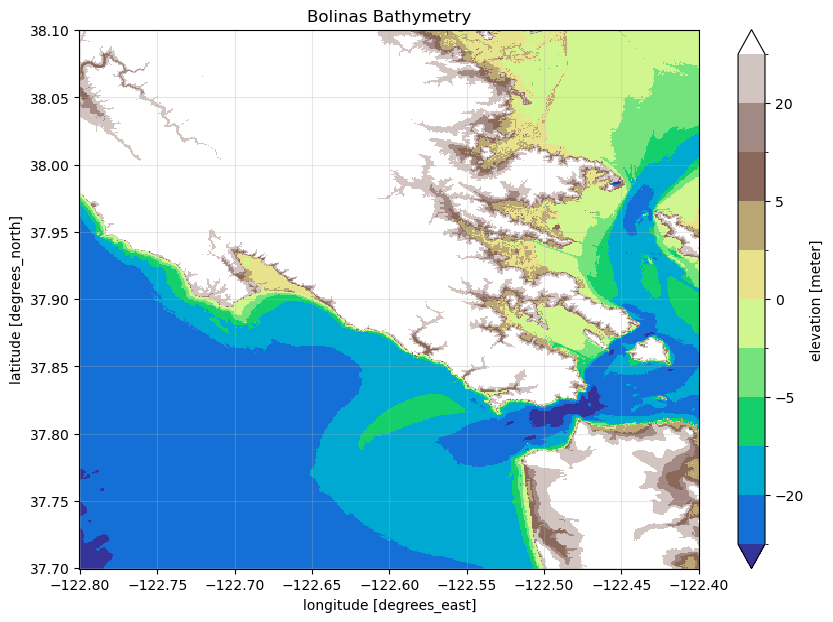

In [4]:
# Define discrete depth brackets
my_levels = [-50, -20, -10, -5, -2, 0, 2, 5, 10, 20, 50]

# Create the plot
plt.figure(figsize=(10, 7))

# Plot the bathymetry
subset.plot(levels=my_levels, cmap='terrain', extend='both')

plt.title("Bolinas Bathymetry")
plt.grid(True, alpha=0.3)
plt.show()

## MOP Nearshore Wave Data

Load and explore MOP station MA147 hindcast and nowcast spectra at Bolinas.

In [5]:
# get mop MA147 nowcast and hindcasts ('the patch' at bolinas)
mop = xr.open_dataset('MA147_nowcast.nc')
mop_h = xr.open_dataset('MA147_hindcast.nc')

In [6]:
print(f'nowcast dates {mop['waveTime'].min().values} to {mop['waveTime'].max().values}') 
print(f'hindcast dates {mop_h['waveTime'].min().values} to {mop_h['waveTime'].max().values}') 

nowcast dates 2025-04-01T00:00:00.000000000 to 2026-01-30T21:00:00.000000000
hindcast dates 2000-01-01T00:00:00.000000000 to 2025-03-31T23:00:00.000000000


In [7]:
# Shore normal angle and peak wave direction stats
print(f"Shore Normal: {mop_h.metaShoreNormal.values}°")
print(f"Peak Direction (Dp): min {mop_h.waveDp.min().values:.1f}°, mean {mop_h.waveDp.mean().values:.1f}°, max {mop_h.waveDp.max().values:.1f}°")

Shore Normal: 148.36000061035156°
Peak Direction (Dp): min 176.7°, mean 215.3°, max 262.0°


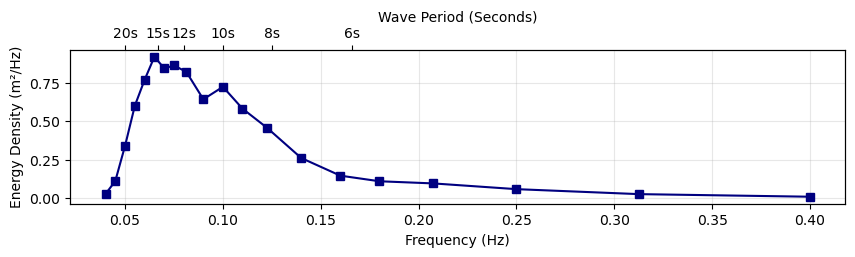

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 2))

# Plot the energy
ax1.plot(mop_h.waveFrequency.values, mop_h.waveEnergyDensity.mean(dim='waveTime').values, 
         marker='s', color='navy', label='Mean Energy Density')

# Add a twin axis for Period
ax2 = ax1.twiny()
# Set the limits to match the frequency axis
ax2.set_xlim(ax1.get_xlim())
# Define the ticks: 20s, 15s, 12s, 10s, 8s, 6s
ticks = np.array([0.05, 0.067, 0.08, 0.1, 0.125, 0.166])
ax2.set_xticks(ticks)
ax2.set_xticklabels([f"{1/t:.0f}s" for t in ticks])

ax1.set_xlabel("Frequency (Hz)")
ax2.set_xlabel("Wave Period (Seconds)")
ax1.set_ylabel("Energy Density (m²/Hz)")
ax1.grid(True, alpha=0.3)
plt.show()

In [9]:
# Calculate the average spectrum 
mean_spectrum = mop_h.waveEnergyDensity.mean(dim='waveTime')

# Find the index of the maximum energy value
peak_idx = mean_spectrum.argmax().values

# Extract the actual peak values using that index
fp = mean_spectrum.waveFrequency.values[peak_idx]
peak_energy = mean_spectrum.values[peak_idx]

print(f"--- Actual Peak Analysis ---")
print(f"Peak Frequency (fp):   {fp:.4f} Hz")
print(f"Peak Energy Density:   {peak_energy:.2f} m^2/Hz")

# Calculate the Peak Period for intuition
print(f"Peak Period (Tp):      {1/fp:.1f} seconds")

--- Actual Peak Analysis ---
Peak Frequency (fp):   0.0650 Hz
Peak Energy Density:   0.92 m^2/Hz
Peak Period (Tp):      15.4 seconds


## Deep-to-Shallow Wave Energy Transformation

Historical comparison of offshore spectra (CDIP 029, Point Reyes) against nearshore model output (MOP MA147) to quantify how wave energy transforms across the shelf into Bolinas.

In [10]:
# get historical cdip 029 data - Point Reyes deep water buoy
cdip_url = (
        "https://thredds.cdip.ucsd.edu/thredds/dodsC/"
        "cdip/archive/029p1/029p1_historic.nc"
    )

cdip_h = xr.open_dataset(cdip_url, engine="netcdf4")

In [11]:
# Check temporal coverage of CDIP buoy record
print(f'CDIP dates {cdip_h["waveTime"].min().values} to {cdip_h["waveTime"].max().values}')

CDIP dates 1996-12-06T01:36:10.000000000 to 2025-10-17T14:30:00.000000000


In [12]:
# Verify both datasets use the same energy density units
print(cdip_h.waveEnergyDensity.units, mop_h.waveEnergyDensity.units)

print("\n--- BUOY FREQUENCY BINS (Hz) ---")
print(cdip_h.waveFrequency.values)

print("\n--- MOP FREQUENCY BINS (Hz) ---")
print(mop_h.waveFrequency.values)

meter^2 second meter^2 second

--- BUOY FREQUENCY BINS (Hz) ---
[0.025   0.03    0.035   0.04    0.045   0.05    0.055   0.06    0.065
 0.07    0.075   0.08    0.085   0.09    0.095   0.10125 0.11    0.12
 0.13    0.14    0.15    0.16    0.17    0.18    0.19    0.2     0.21
 0.22    0.23    0.24    0.25    0.26    0.27    0.28    0.29    0.3
 0.31    0.32    0.33    0.34    0.35    0.36    0.37    0.38    0.39
 0.4     0.41    0.42    0.43    0.44    0.45    0.46    0.47    0.48
 0.49    0.5     0.51    0.52    0.53    0.54    0.55    0.56    0.57
 0.58   ]

--- MOP FREQUENCY BINS (Hz) ---
[0.04   0.045  0.05   0.055  0.06   0.065  0.07   0.075  0.0813 0.09
 0.1    0.11   0.1225 0.14   0.16   0.18   0.2075 0.25   0.3125 0.4   ]


### Frequency Alignment & Snapshot Comparison

Interpolate MOP onto the buoy frequency grid and compare spectra at a single timestep.

In [13]:
# Align Frequency: Interpolate MOP's 20 bins to match the Buoy's 64 bins
# We use linear interpolation to bridge the gaps (like the 0.08 to 0.0813 Hz gap)
mop_aligned = mop_h.interp(waveFrequency=cdip_h.waveFrequency, method='linear')

# Align Time: Find the exact overlap between the Buoy and the Model
# This handles the transition from Hindcast to Nowcast automatically
common_times = np.intersect1d(cdip_h.waveTime, mop_aligned.waveTime)

# Create the Mastered Datasets (Perfectly synced in time and frequency)
buoy_master = cdip_h.sel(waveTime=common_times)
mop_master = mop_aligned.sel(waveTime=common_times)

print(f"Universal alignment complete.")
print(f"Time steps: {len(common_times)}")
print(f"Buoy Frequency bins: {len(buoy_master.waveFrequency)}")
print(f"MOP Frequency bins: {len(mop_master.waveFrequency)}")

Universal alignment complete.
Time steps: 67179
Buoy Frequency bins: 64
MOP Frequency bins: 64


In [14]:
# Test case for comparing offshore vs nearshore response
target_time = '2024-01-20T12:00:00'

# sel(method='nearest') handles the time lookup
buoy_slice = buoy_master.sel(waveTime=target_time, method='nearest')
mop_slice = mop_master.sel(waveTime=target_time, method='nearest')

b_energy = pd.Series(buoy_slice.waveEnergyDensity.values, index=buoy_slice.waveFrequency.values)
m_energy = pd.Series(mop_slice.waveEnergyDensity.values, index=mop_slice.waveFrequency.values)
b_dir = pd.Series(buoy_slice.waveMeanDirection.values, index=buoy_slice.waveFrequency.values)

# Reindex MOP to match Buoy frequencies
# 'nearest' finds the closest match; 'tolerance' ensures we don't match things too far apart
m_energy_aligned = m_energy.reindex(b_energy.index, method='nearest', tolerance=0.01)

# Combine into a clean table
comparison = pd.DataFrame({
    'Period (s)': (1 / b_energy.index).round(1),
    'Buoy_Energy': b_energy,
    'MOP_Energy_Aligned': m_energy_aligned,
    'Buoy_Dir': b_dir,
    'Energy_Ratio': (m_energy_aligned / b_energy).round(3)
})

print(f"--- Aligned Spectral Slice: {target_time} ---")
# Display the main swell energy (10s to 20s)
print(comparison.loc[0.05:0.1].sort_index())

--- Aligned Spectral Slice: 2024-01-20T12:00:00 ---
       Period (s)  Buoy_Energy  MOP_Energy_Aligned   Buoy_Dir  Energy_Ratio
0.050   20.000000     0.118504            0.050679  211.28125         0.428
0.055   18.200001     0.252131            0.248690  254.87500         0.986
0.060   16.700001     1.910172            0.954637  270.34375         0.500
0.065   15.400000     2.821286            0.785107  247.84375         0.278
0.070   14.300000     1.299778            0.474456  235.18750         0.365
0.075   13.300000     2.264135            0.527772  253.46875         0.233
0.080   12.500000     1.754516            2.097893  249.25000         1.196
0.085   11.800000    14.471670            2.719392  252.06250         0.188
0.090   11.100000    15.755554            3.007591  250.65625         0.191
0.095   10.500000     9.320283            2.942307  249.25000         0.316


## Period-Band Ratio Analysis

For each 1-second period band, compute the shallow-to-deep wave height ratio as a function of wave direction.

In [15]:
def calculate_period_group_ratios(mop_h, buoy_h, period_min, period_max):
    """Compare wave energy between MOP (shallow) and CDIP buoy (deep) for a given period band.

    Slices both datasets to the frequency range corresponding to [period_min, period_max],
    integrates energy density across those bins, then computes the height ratio
    (sqrt of shallow/deep energy) for each overlapping timestep. Returns a DataFrame
    with time, peak wave direction, height ratio, and 10-degree direction bins.

    Args:
        mop_h: xarray Dataset of MOP shallow-water hindcast spectra.
        buoy_h: xarray Dataset of CDIP deep-water buoy spectra.
        period_min: Lower bound of the wave period window (seconds).
        period_max: Upper bound of the wave period window (seconds).

    Returns:
        pd.DataFrame with columns: time, direction, height_ratio, group, dir_bin.
    """
    start_time = time.time()
    
    f_high = 1.0 / period_min
    f_low = 1.0 / period_max
    print(f"--- Analyzing Group: {period_min}-{period_max}s ---")
    
    # Shift and Align Time
    buoy_h_offset = buoy_h.copy()
    buoy_h_offset['waveTime'] = buoy_h_offset.waveTime + np.timedelta64(1, 'h')
    mop_t = mop_h.sel(waveTime=slice('2003', '2025-03-31'))
    buoy_t = buoy_h_offset.sel(waveTime=slice('2003', '2025-03-31'))

    # Slice Frequency
    mop_slice = mop_t.sel(waveFrequency=slice(f_low, f_high))
    buoy_slice = buoy_t.sel(waveFrequency=slice(f_low, f_high))
    
    # Fallback for narrow windows (Ensure they stay 1D for consistent math)
    if mop_slice.waveFrequency.size == 0:
        f_mid = (f_low + f_high) / 2
        mop_slice = mop_t.sel(waveFrequency=[f_mid], method='nearest')
        buoy_slice = buoy_t.sel(waveFrequency=[f_mid], method='nearest')

    # Calculate Energy Area (Integration Logic)
    def get_energy_total(ds):
        f_vals = ds.waveFrequency.values
        # If we have multiple bins, use the gap between them as bandwidth
        if f_vals.size > 1:
            df = np.gradient(f_vals).mean()
        else:
            # If only one bin, the bandwidth is the whole 1-second window
            df = f_high - f_low
        return (ds.waveEnergyDensity.sum(dim='waveFrequency') * df).compute()

    # Pull the data from the server
    mop_m0 = get_energy_total(mop_slice)
    buoy_m0 = get_energy_total(buoy_slice)
    # Find the index of the frequency with the maximum energy (the peak)
    peak_idx = buoy_slice.waveEnergyDensity.argmax(dim='waveFrequency')
    
    # Pull the direction from that specific peak frequency index
    buoy_dir = buoy_slice.waveMeanDirection.isel(waveFrequency=peak_idx).compute().squeeze()

    
    # Align Time Series
    common_time = np.intersect1d(mop_m0.waveTime, buoy_m0.waveTime)
    m_ds = mop_m0.sel(waveTime=common_time)
    b_ds = buoy_m0.sel(waveTime=common_time)
    d_ds = buoy_dir.sel(waveTime=common_time)

    # Apply Filter & Calculate HEIGHT Ratio
    b_val = b_ds.values
    m_val = m_ds.values
    
    # Filter for waves > 0.3m offshore
    b_hs = 4 * np.sqrt(b_val)
    valid_mask = (b_hs > 0.3) & (b_val > 0) & (m_val > 0)

    # Final DataFrame
    df = pd.DataFrame({
        'time': m_ds.waveTime.values[valid_mask],
        'direction': d_ds.values[valid_mask],
        'height_ratio': np.sqrt(m_val[valid_mask] / b_val[valid_mask]),
        'group': period_min
    })
    
    df['dir_bin'] = (np.floor(df['direction'] / 10) * 10).astype(int)
    
    print(f"   Done! {len(df)} records. ({time.time() - start_time:.1f}s)")
    return df

In [16]:
# Create a list to store all the discrete period DFs
period_dfs = []
period_range = (10,19)
# Loop through each individual second
for p in range(*period_range):  
    # We use a very tight window around the target period (e.g., 11.5 to 12.5)
    # to isolate that specific frequency's behavior
    df_p = calculate_period_group_ratios(mop_h, cdip_h, p, p + 0.99)
    
    # Update the group name to just the integer for easier plotting
    df_p['group'] = p 
    period_dfs.append(df_p)

# Combine them all into one master "Spectral" DataFrame
df_spectral = pd.concat(period_dfs)

--- Analyzing Group: 10-10.99s ---
   Done! 50952 records. (1.4s)
--- Analyzing Group: 11-11.99s ---
   Done! 50262 records. (0.6s)
--- Analyzing Group: 12-12.99s ---
   Done! 40976 records. (0.4s)
--- Analyzing Group: 13-13.99s ---
   Done! 38143 records. (0.4s)
--- Analyzing Group: 14-14.99s ---
   Done! 35158 records. (0.4s)
--- Analyzing Group: 15-15.99s ---
   Done! 29374 records. (0.5s)
--- Analyzing Group: 16-16.99s ---
   Done! 20235 records. (0.4s)
--- Analyzing Group: 17-17.99s ---
   Done! 10523 records. (0.4s)
--- Analyzing Group: 18-18.99s ---
   Done! 9659 records. (0.4s)


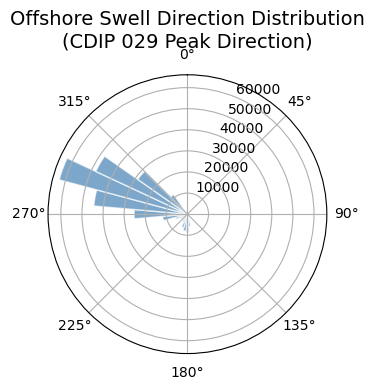

In [17]:
# Polar histogram of wave direction distribution
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': 'polar'})

dir_counts = df_spectral['dir_bin'].value_counts().sort_index()
theta = np.deg2rad(dir_counts.index)  # axes already in compass convention
width = np.deg2rad(10)  # 10-degree bins

bars = ax.bar(theta, dir_counts.values, width=width, alpha=0.7, color='steelblue', edgecolor='white')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  # clockwise, like a compass
ax.set_title('Offshore Swell Direction Distribution\n(CDIP 029 Peak Direction)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## Direction-Filtered Height Ratios

Filter for statistically significant direction/period bins and compute median transformation ratios.

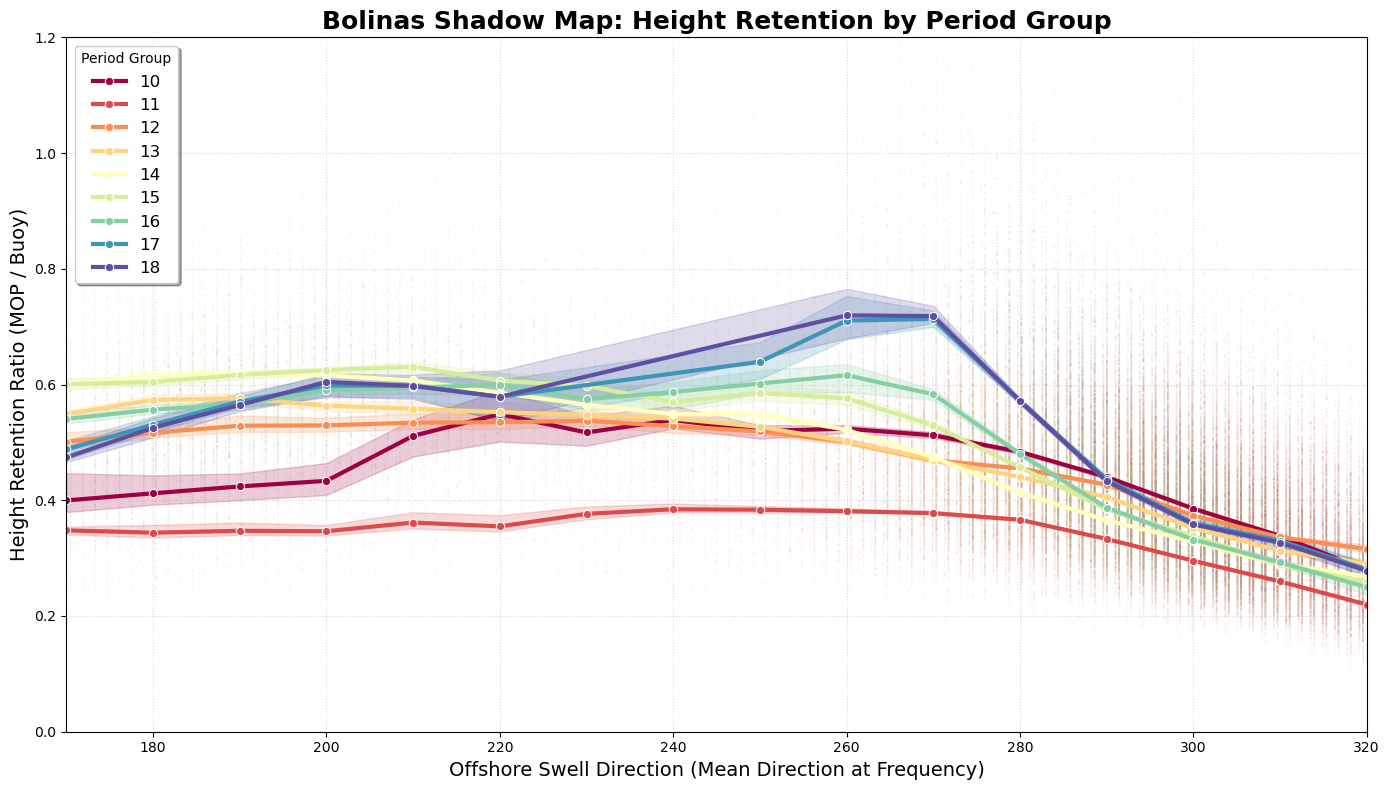

In [18]:
# Filtering - count how many observations exist for each (Period Group + Direction Bin)
counts = df_spectral.groupby(['group', 'dir_bin']).size().reset_index(name='sample_count')

# Merge those counts back into the main data
df_plot = df_spectral.merge(counts, on=['group', 'dir_bin'])

# Define the threshold (e.g., at least 100 hours of data to trust the median)
threshold = 100
df_filtered = df_plot[df_plot['sample_count'] >= threshold]

# Set up the figure
plt.figure(figsize=(14, 8))

# Create a dynamic color palette
cmap = plt.get_cmap('Spectral')
colors = cmap(np.linspace(0, 1, len(range(*period_range))))
palette = {p: colors[i] for i, p in enumerate(range(*period_range))}

# Plot the Raw Data
sns.scatterplot(
    data=df_filtered, x='direction', y='height_ratio', hue='group', 
    palette=palette, alpha=0.03, s=2, legend=False
)

# Plot the Median Trend Lines
sns.lineplot(
    data=df_filtered, x='dir_bin', y='height_ratio', hue='group', 
    palette=palette, lw=3, marker='o', markersize=6,
    estimator=np.median, 
    errorbar=('ci', 95),  # This adds the shaded uncertainty bands
    err_style='band'      # 'band' is cleaner than 'bars' for multiple lines
)

# Final Formatting
plt.title("Bolinas Shadow Map: Height Retention by Period Group", fontsize=18, fontweight='bold')
plt.xlabel("Offshore Swell Direction (Mean Direction at Frequency)", fontsize=14)
plt.ylabel("Height Retention Ratio (MOP / Buoy)", fontsize=14)

plt.xlim(170, 320)
plt.ylim(0, 1.2) 

# Customizing the legend
plt.legend(title="Period Group", loc='upper left', frameon=True, shadow=True, fontsize=12)
plt.grid(True, which='both', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

### Seasonal Analysis

Which direction-period combinations dominate each season? Anomaly heatmaps show the deviation from annual average observation counts — blue means that bin is more common in that season, red means less common. The overlay plots show how retention varies by season at key directions.

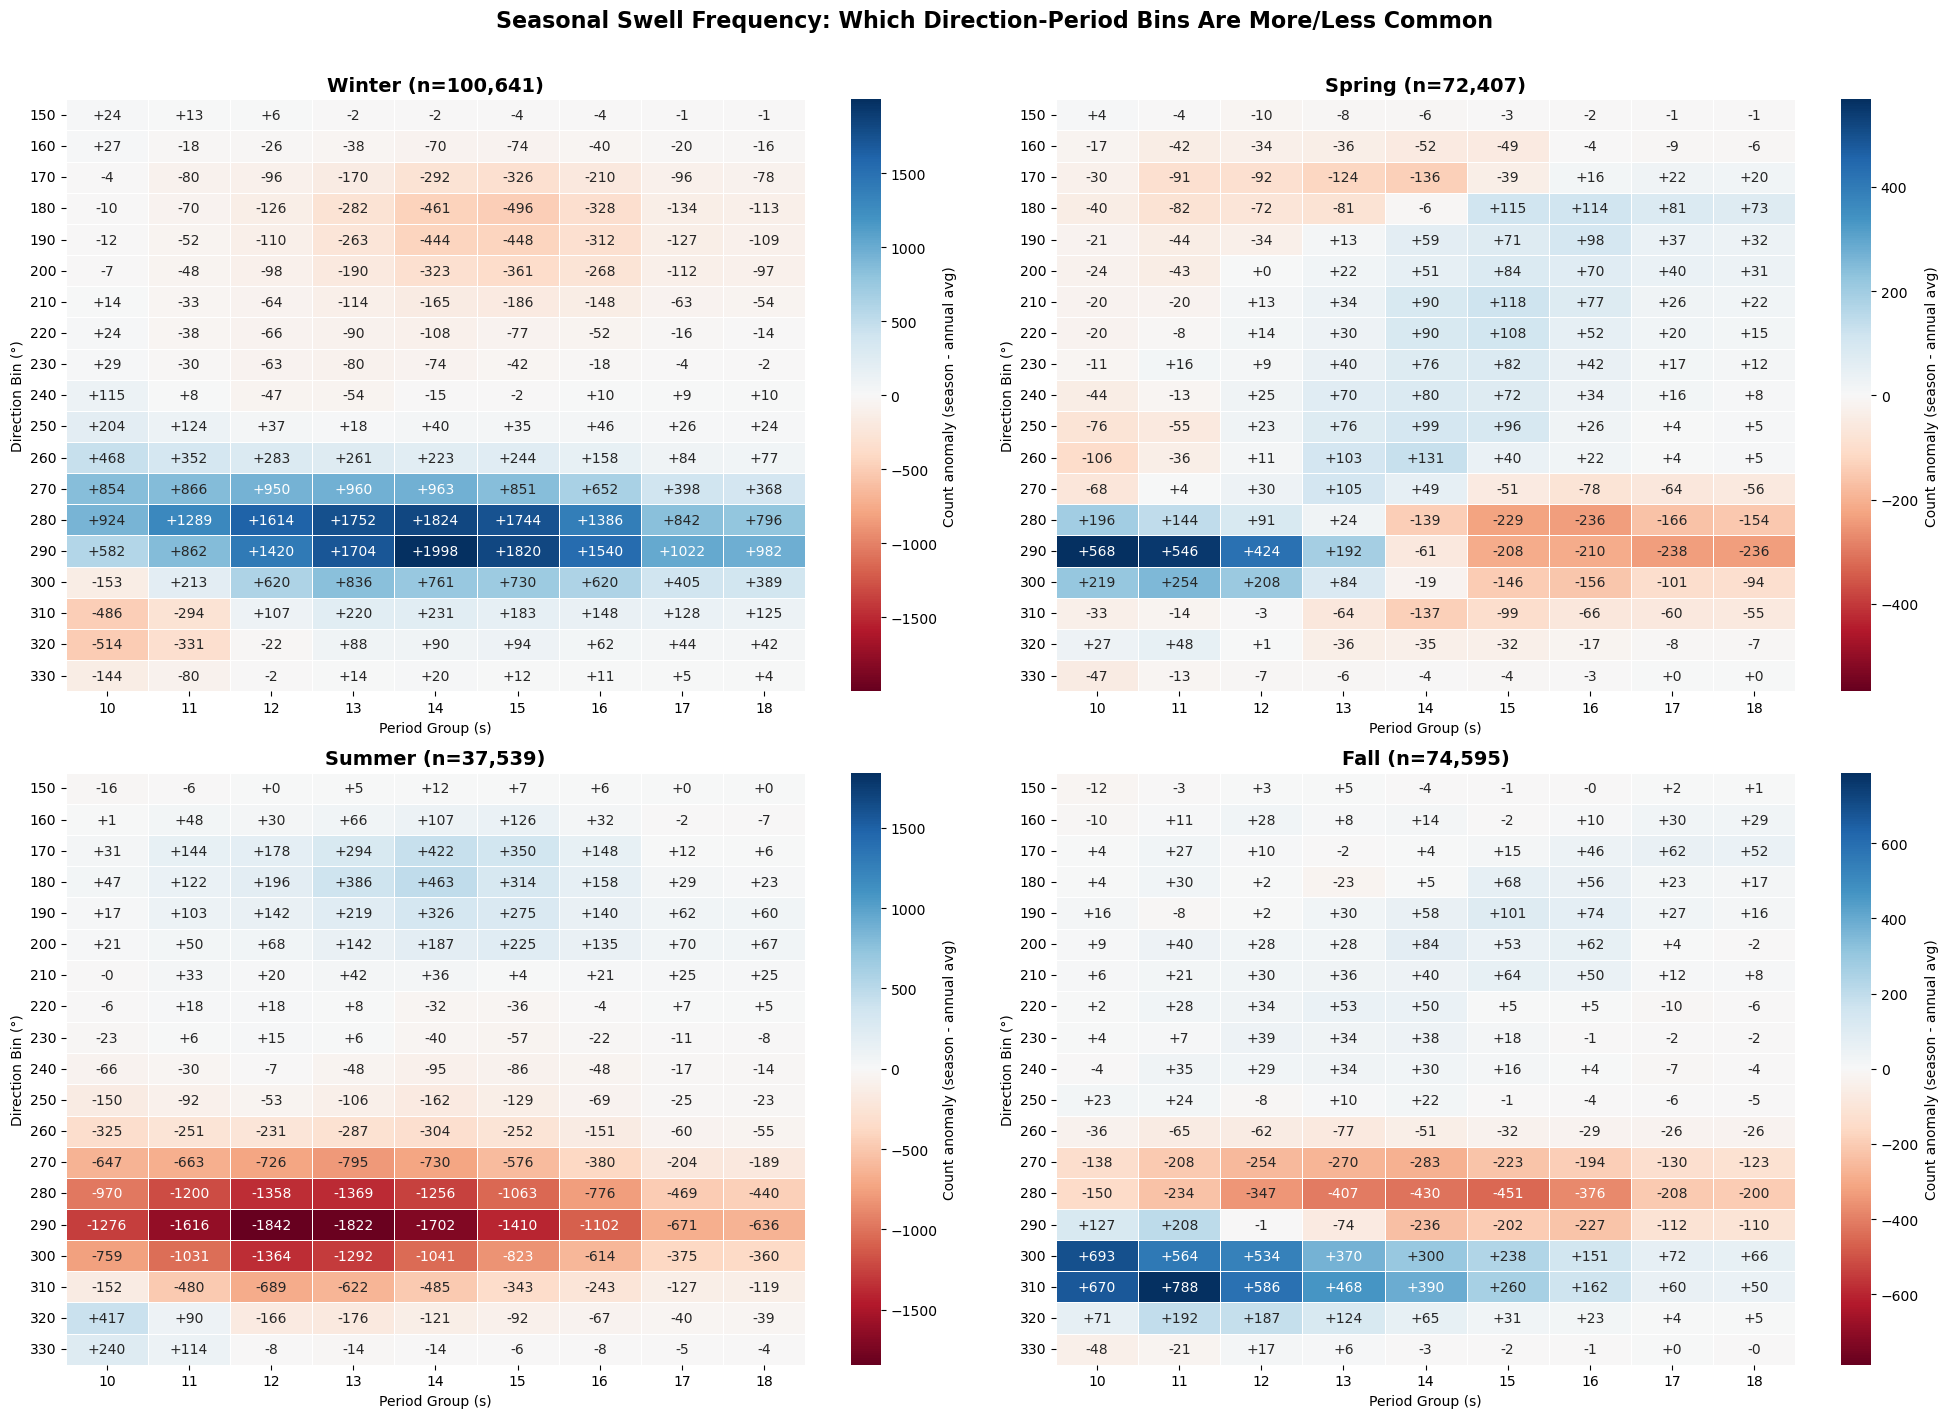

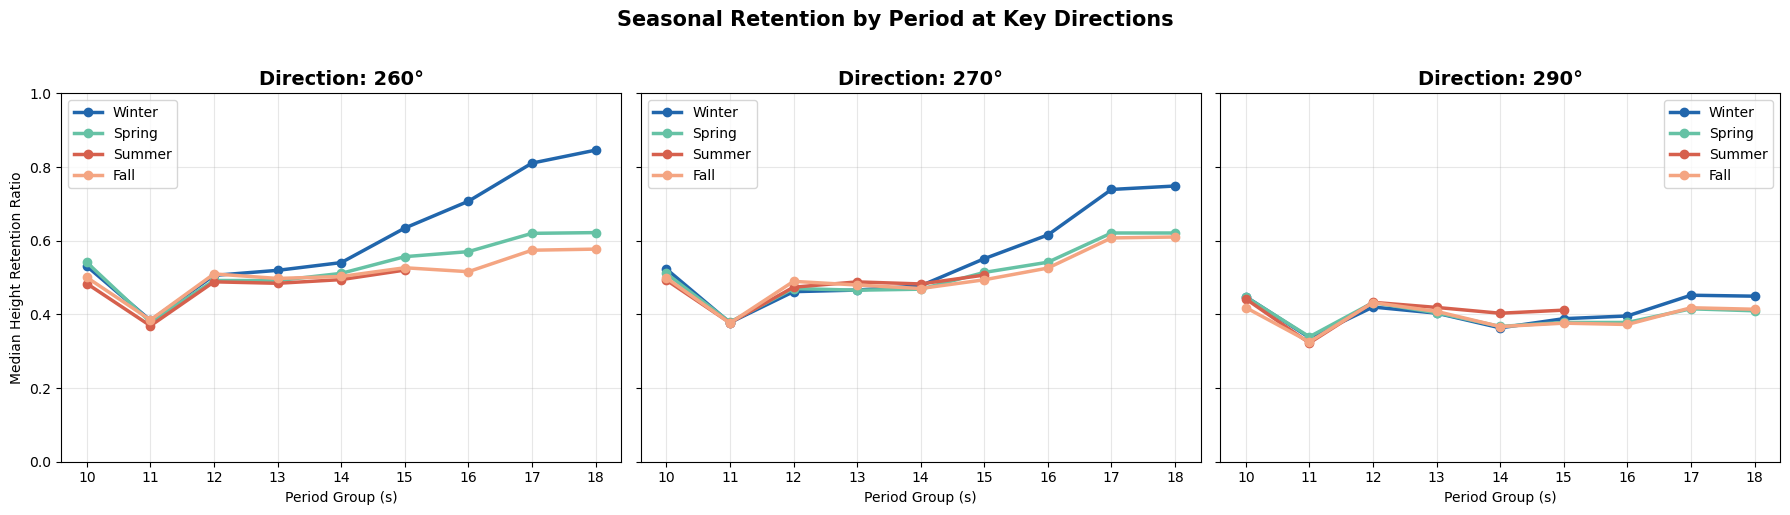

In [19]:
# Split ratios by season
df_seasonal = df_spectral[(df_spectral['direction'] >= 150) & (df_spectral['direction'] <= 340)].copy()
df_seasonal['month'] = pd.to_datetime(df_seasonal['time']).dt.month
df_seasonal['season'] = df_seasonal['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Annual average counts per direction-period bin
annual_counts = df_seasonal.groupby(['dir_bin', 'group']).size().unstack(fill_value=0) / 4

# --- Count anomaly heatmaps ---
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

for ax, season in zip(axes.flat, ['Winter', 'Spring', 'Summer', 'Fall']):
    df_s = df_seasonal[df_seasonal['season'] == season]
    season_counts = df_s.groupby(['dir_bin', 'group']).size().unstack(fill_value=0)
    # Reindex to match annual so subtraction aligns
    season_counts = season_counts.reindex_like(annual_counts).fillna(0)
    anomaly = season_counts - annual_counts
    # Determine symmetric color scale
    vmax = max(abs(anomaly.min().min()), abs(anomaly.max().max()))
    sns.heatmap(
        anomaly, annot=True, fmt='+.0f',
        cmap='RdBu', center=0, vmin=-vmax, vmax=vmax,
        linewidths=0.5, ax=ax,
        cbar_kws={'label': 'Count anomaly (season - annual avg)'}
    )
    n_obs = len(df_s)
    ax.set_title(f'{season} (n={n_obs:,})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Period Group (s)')
    ax.set_ylabel('Direction Bin (°)')

plt.suptitle('Seasonal Swell Frequency: Which Direction-Period Bins Are More/Less Common',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# --- Season overlay at key direction bins ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
season_colors = {'Winter': '#2166ac', 'Spring': '#66c2a5', 'Summer': '#d6604d', 'Fall': '#f4a582'}

for ax, dir_bin in zip(axes, [260, 270, 290]):
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        df_s = df_seasonal[(df_seasonal['season'] == season) & (df_seasonal['dir_bin'] == dir_bin)]
        if df_s.empty:
            continue
        # Only keep period bins with >= 25 observations
        counts = df_s.groupby('group')['height_ratio'].count()
        valid_groups = counts[counts >= 25].index
        medians = df_s[df_s['group'].isin(valid_groups)].groupby('group')['height_ratio'].median()
        ax.plot(medians.index, medians.values, marker='o', lw=2.5,
                label=season, color=season_colors[season])
    ax.set_title(f'Direction: {dir_bin}°', fontsize=14, fontweight='bold')
    ax.set_xlabel('Period Group (s)')
    ax.set_ylim(0, 1.0)
    ax.grid(True, alpha=0.3)
    if dir_bin == 260:
        ax.set_ylabel('Median Height Retention Ratio')
    ax.legend(fontsize=10)

plt.suptitle('Seasonal Retention by Period at Key Directions',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Swell-Size Dependence

Does the transformation ratio change with offshore swell size? Compute broadband Hs from the CDIP buoy spectrum, merge with the ratio data, and compare retention across small, medium, and large swell events.

Offshore Hs range: 0.7 - 12.1m

Bin counts:
hs_bin
< 1.5m       11806
1.5-2.5m     83168
2.5-4m      116920
> 4m         72179
Name: count, dtype: int64


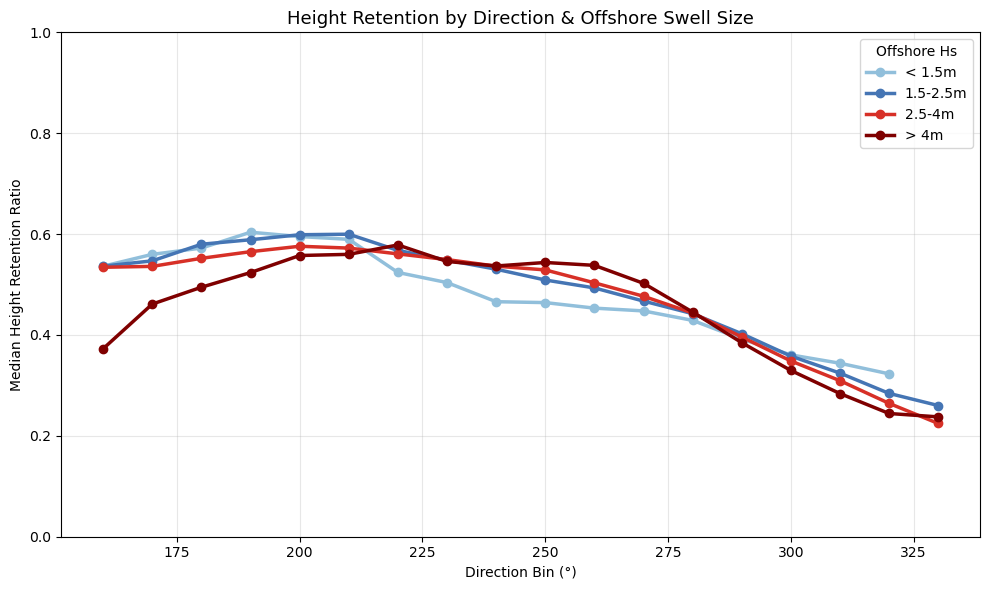

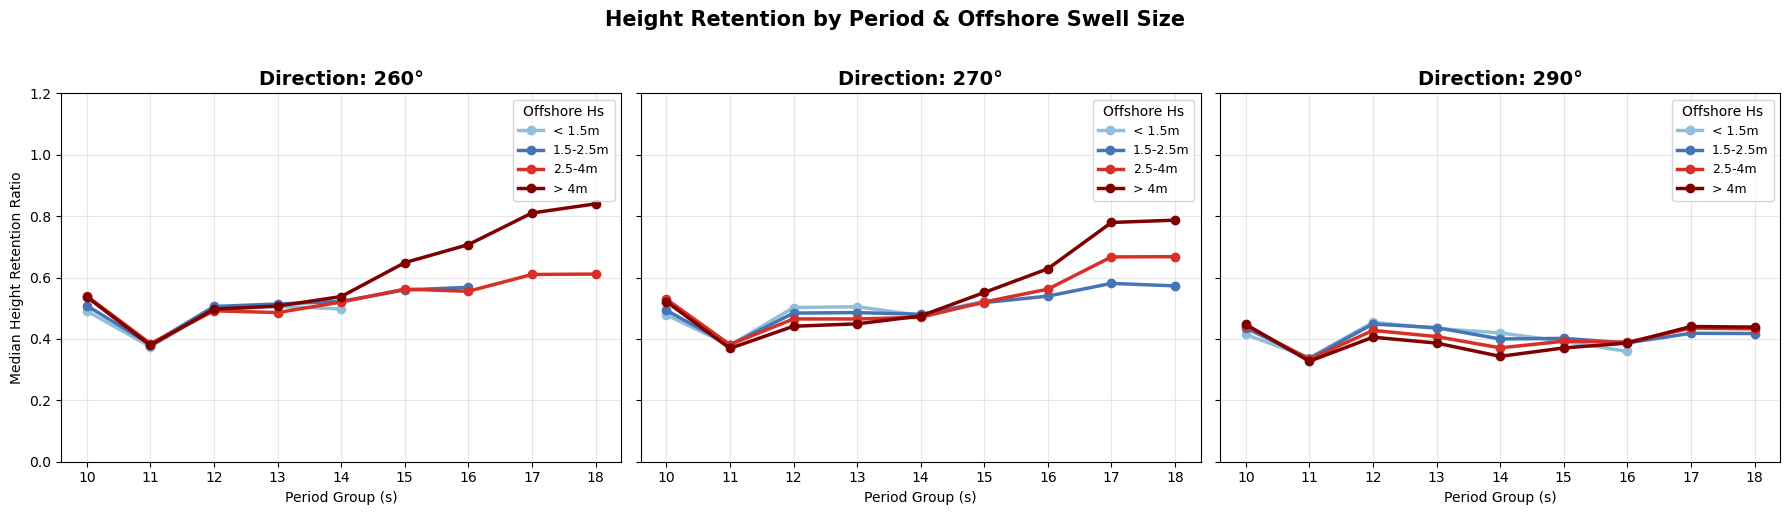

In [20]:
# Compute broadband Hs from CDIP buoy for each timestep
# Hs = 4 * sqrt(m0) where m0 = integral of E(f) df
buoy_df = np.gradient(cdip_h.waveFrequency.values).mean()  # frequency bandwidth
buoy_m0 = (cdip_h.waveEnergyDensity.sum(dim='waveFrequency') * buoy_df).compute()
buoy_hs = 4 * np.sqrt(buoy_m0)

# Build a time-indexed Series of offshore Hs
# Apply the same 1-hour offset used in the ratio analysis
hs_times = cdip_h.waveTime.values + np.timedelta64(1, 'h')
hs_series = pd.Series(buoy_hs.values, index=hs_times, name='offshore_hs')

# Merge offshore Hs into the filtered ratio DataFrame
df_size = df_filtered.copy()
df_size['time_idx'] = pd.to_datetime(df_size['time'])
df_size = df_size.set_index('time_idx')
df_size['offshore_hs'] = hs_series.reindex(df_size.index, method='nearest', tolerance=pd.Timedelta('1h'))
df_size = df_size.dropna(subset=['offshore_hs']).reset_index(drop=True)

# Bin by offshore Hs
df_size['hs_bin'] = pd.cut(
    df_size['offshore_hs'],
    bins=[0, 1.5, 2.5, 4.0, 20],
    labels=['< 1.5m', '1.5-2.5m', '2.5-4m', '> 4m']
)

print(f'Offshore Hs range: {df_size["offshore_hs"].min():.1f} - {df_size["offshore_hs"].max():.1f}m')
print(f'\nBin counts:\n{df_size["hs_bin"].value_counts().sort_index()}')

# --- Plot 1: Retention vs direction, split by swell size ---
fig, ax = plt.subplots(figsize=(10, 6))

size_colors = {'< 1.5m': '#91bfdb', '1.5-2.5m': '#4575b4', '2.5-4m': '#d73027', '> 4m': '#7f0000'}

# Left: Retention vs direction for each size bin (all periods pooled)
for hs_bin in ['< 1.5m', '1.5-2.5m', '2.5-4m', '> 4m']:
    df_b = df_size[df_size['hs_bin'] == hs_bin]
    medians = df_b.groupby('dir_bin')['height_ratio'].median()
    # Filter for bins with >= 25 observations
    counts = df_b.groupby('dir_bin')['height_ratio'].count()
    valid = counts[counts >= 25].index
    medians = medians[medians.index.isin(valid)]
    ax.plot(medians.index, medians.values, marker='o', lw=2.5,
                 label=hs_bin, color=size_colors[hs_bin])

ax.set_title('Height Retention by Direction & Offshore Swell Size', fontsize=13)
ax.set_xlabel('Direction Bin (°)')
ax.set_ylabel('Median Height Retention Ratio')
ax.set_ylim(0, 1.0)
ax.legend(title='Offshore Hs')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Plot 2: Retention vs period at key directions, split by swell size ---
fig, axes2 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, dir_bin in zip(axes2, [260, 270, 290]):
    df_dir = df_size[df_size['dir_bin'] == dir_bin]
    for hs_bin in ['< 1.5m', '1.5-2.5m', '2.5-4m', '> 4m']:
        df_b = df_dir[df_dir['hs_bin'] == hs_bin]
        medians = df_b.groupby('group')['height_ratio'].median()
        counts = df_b.groupby('group')['height_ratio'].count()
        valid = counts[counts >= 25].index
        medians = medians[medians.index.isin(valid)]
        if not medians.empty:
            ax.plot(medians.index, medians.values, marker='o', lw=2.5,
                    label=hs_bin, color=size_colors[hs_bin])
    ax.set_title(f'Direction: {dir_bin}°', fontsize=14, fontweight='bold')
    ax.set_xlabel('Period Group (s)')
    ax.set_ylim(0, 1.2)
    ax.grid(True, alpha=0.3)
    if dir_bin == 260:
        ax.set_ylabel('Median Height Retention Ratio')
    ax.legend(title='Offshore Hs', fontsize=9)

plt.suptitle('Height Retention by Period & Offshore Swell Size',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Summary

The direction-filtered ratio analysis reveals clear period and direction dependencies in how wave energy reaches Bolinas moving from deepwater CDIP 029 buoy (~600m depth) to the nearshore MOP point at Bolinas (15m depth):

**Direction**: Swells from the SSW-to-W window (190-270°) retain the most energy, with median ratios of 0.45-0.65. Retention drops sharply for NW swells — the 310-330° bins retain only 0.23-0.35 of offshore height, consistent with sheltering by Point Reyes and refraction losses over Duxbury Reef.

**Period**: Longer-period swells refract more effectively into Bolinas. The 16-18s bands at 260-270° achieve the highest overall ratios (0.58-0.70), while shorter 10-11s swells from those same directions retain roughly half as much (0.38-0.52) because their shallower wave base prevents them from interacting with the offshore bathymetry as early or as deeply as the long-period energy. 

**Seasonality**: Winter dominates the swell climate with long-period NW energy (270-300°, 14-18s), while summer has roughly one-third the observations and skews toward shorter-period, more southerly swell. 

**Swell Size & Shoaling**: Larger offshore swells (>4m Hs) retain disproportionately more energy at 260-270° for long periods — reaching 0.80-0.85 at 17-18s, roughly 60% higher than small/medium swells in the same bins. This suggests that at the 15m depth contour, larger long-period waves are undergoing significant shoaling-induced amplification and bathymetric convergence, concentrating their energy before they reach the breaking point. This nonlinear amplification with swell size is notably absent at 290°, where sheltering likely dominates regardless of wave height.

**Key takeaway**: The Patch at Bolinas is most exposed to long-period W-WNW swell (260-270°, 15s+), and most sheltered from NW groundswell (300°+). The 280° bin marks a sharp transition — retention drops ~30% compared to 270° across all periods. The strongest surf events are the combination of large (>4m), long-period (16s+), W-directed (260-270°) swells — conditions most common in winter — where bathymetric focusing produces the highest retention ratios in the dataset.